# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix

# Functions

In [2]:
def tree_metrics(model,Xv,yv):
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

In [3]:
def nn_metrics(model,Xv,yv):
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

# Data

In [4]:
df = pd.read_csv(r"healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
#We don't need to drop any duplicate records
df.shape, len(df["id"])

((5110, 12), 5110)

In [6]:
#Just 5% of the dataset has a positive target value
df["stroke"].value_counts(True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

# Cleaning / Preprocessing

In [7]:
varc = ["age", "avg_glucose_level", "bmi"]
tgt = ["stroke"]
vard = [var for var in df.columns.tolist() if var not in (varc+tgt+["id"])]

In [8]:
#We're dropping these NA values as they are less <5%
df[df["bmi"].isna()].shape[0]/df.shape[0]*100

3.9334637964774952

In [9]:
df.drop(columns=("id"), axis = 1, inplace = True)

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4904,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
4905,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
4906,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
4907,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Discrete Variables

In [11]:
#We check for any unknown categories
for col in df[vard].columns.to_list():
    print("\n"+col+"\n")
    print(df[col].value_counts(True))


gender

Female    0.590141
Male      0.409656
Other     0.000204
Name: gender, dtype: float64

hypertension

0    0.908128
1    0.091872
Name: hypertension, dtype: float64

heart_disease

0    0.950499
1    0.049501
Name: heart_disease, dtype: float64

ever_married

Yes    0.652679
No     0.347321
Name: ever_married, dtype: float64

work_type

Private          0.572622
Self-employed    0.157873
children         0.136688
Govt_job         0.128336
Never_worked     0.004482
Name: work_type, dtype: float64

Residence_type

Urban    0.507232
Rural    0.492768
Name: Residence_type, dtype: float64

smoking_status

never smoked       0.377266
Unknown            0.302098
formerly smoked    0.170503
smokes             0.150132
Name: smoking_status, dtype: float64


In [12]:
#We can drop all values on te columns below as they are non relevant

In [13]:
df[df["work_type"] == "Never_worked"].shape[0]/df.shape[0]*100
df = df[df["work_type"] != "Never_worked"].reset_index(drop=True)

In [14]:
df[df["gender"] == "Other"].shape[0]/df.shape[0]*100
df = df[df["gender"] != "Other"].reset_index(drop=True)

### Dummies

In [15]:
temp = pd.get_dummies(df[vard])

In [16]:
df = df.join(temp, rsuffix="_dummy")

In [17]:
df.drop(columns=(vard), inplace = True, axis = 1)

In [18]:
df

,age,avg_glucose_level,bmi,stroke,hypertension_dummy,heart_disease_dummy,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80.0,105.92,32.5,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49.0,171.23,34.4,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,79.0,174.12,24.0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,81.0,186.21,29.0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4881,13.0,103.08,18.6,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0
4882,81.0,125.20,40.0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
4883,35.0,82.99,30.6,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4884,51.0,166.29,25.6,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0


## Continuous Variables

In [19]:
df[varc].describe(percentiles=[0.01,0.1,0.9,0.99]).T

,count,mean,std,min,1%,10%,50%,90%,99%,max
age,4886.0,42.988973,22.534968,0.08,1.0800,10.000,45.00,74.000,82.000,82.00
avg_glucose_level,4886.0,105.339073,44.481347,55.12,56.3185,65.645,91.68,187.495,240.608,271.74
bmi,4886.0,28.909640,7.853621,10.30,15.1000,19.700,28.10,38.900,53.415,97.60


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>],
       [<AxesSubplot:title={'center':'bmi'}>, <AxesSubplot:>]],
      dtype=object)

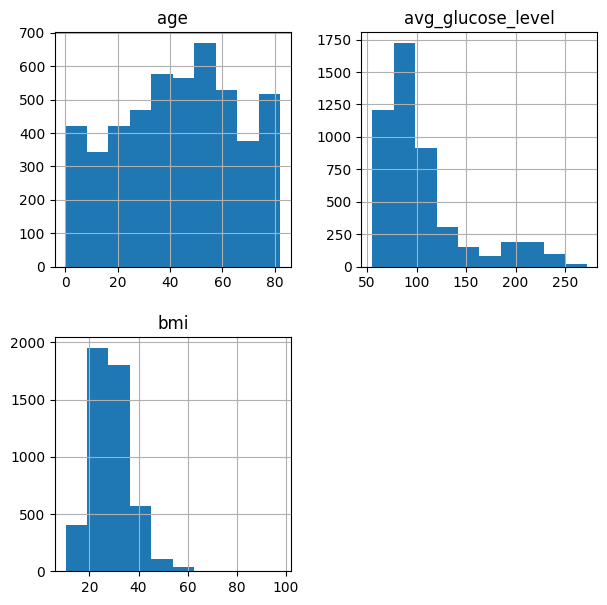

In [20]:
df[varc].hist(figsize=(7,7))

### Outliers

In [21]:
ext = df[varc].describe(percentiles=[0.005,0.995]).T[['0.5%','99.5%']].reset_index()
for v, li, ls in ext.values:
    df[f'ol_{v}'] = ( (df[v]<li) | (df[v]>ls)  ).astype(int)
    
df['ext'] = df.filter(like='ol_').max(axis=1)

In [22]:
df.drop(df.filter(like='ol_').columns, axis=1, inplace=True)

In [23]:
df['ext'].value_counts(True)

0    0.976054
1    0.023946
Name: ext, dtype: float64

In [24]:
df = df.loc[df["ext"] == 0].reset_index(drop=True).drop(["ext"], axis=1)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>],
       [<AxesSubplot:title={'center':'bmi'}>, <AxesSubplot:>]],
      dtype=object)

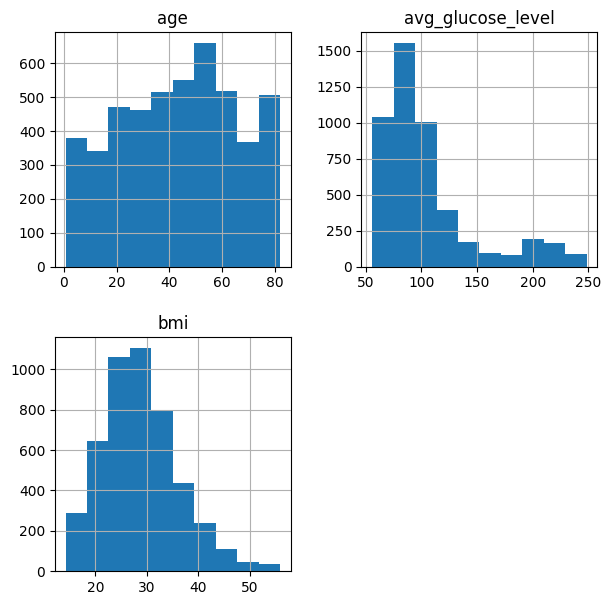

In [25]:
df[varc].hist(figsize=(7,7))

# Decision Tree

In [26]:
#We create a separate DF in order to use for the decision tree classifier
Tree_data = df.copy()

In [27]:
Xt = Tree_data[[col for col in Tree_data.columns.tolist() if col not in tgt]]
Yt = Tree_data[tgt]

In [28]:
Xt_t, Xt_v, Yt_t, Yt_v = train_test_split(Xt, Yt, test_size = 0.3, random_state = 100)

## Scaling Values

In [29]:
sc_tree = StandardScaler()

In [30]:
Xt_t[varc] = sc_tree.fit_transform(Xt_t[varc])

In [31]:
Xt_v[varc] = sc_tree.transform(Xt_v[varc])

## Model

In [32]:
Tree_Classifier = DecisionTreeClassifier()

In [33]:
Tree_Classifier.fit(Xt_t, Yt_t)

DecisionTreeClassifier()

In [34]:
Yt_pred = Tree_Classifier.predict(Xt_v)

## Metrics

In [35]:
pd.DataFrame(Yt_pred).value_counts(normalize = True)

0    0.951782
1    0.048218
dtype: float64

In [36]:
tree_metrics(Tree_Classifier,Xt_t, Yt_t)

 Roc Validate: 1.000
 Acc Validate: 1.000
 Matrix Conf Validate:  
 [[3198    0]
 [   0  140]]


In [37]:
tree_metrics(Tree_Classifier,Xt_v, Yt_v)

 Roc Validate: 0.542
 Acc Validate: 0.920
 Matrix Conf Validate:  
 [[1308   61]
 [  54    8]]


## Hyper params

In [38]:
param_grid = {"max_depth": range(1, 5),
              "max_features": ["auto", "sqrt", "log2"],
              "min_samples_leaf": [x/100 for x in range(5, 51, 1)] + [x for x in range(1, 21)], 
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"],
              "class_weight": ["balanced", None]}

In [39]:
Random=RandomizedSearchCV(DecisionTreeClassifier(),param_grid,scoring='roc_auc',n_iter=1000,cv=3,verbose=1,n_jobs=-1,)

In [40]:
Random.fit(Xt_t,Yt_t)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecate

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecate

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecate

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecate

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecate

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecate

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 5),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [0.05, 0.06, 0.07,
                                                             0.08, 0.09, 0.1,
                                                             0.11, 0.12, 0.13,
                                                             0.14, 0.15, 0.16,
                                                             0.17, 0.18, 0.19,
                                                             0.2, 0.21, 0.22,
                                                             0.23, 0.24, 0.25,
                                                             0.26, 0.27, 0.28,
                                                             0.29, 0.3, 0.31,
                                                             0.32, 0.33, 0.34, ...],
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc', verbose=1)

In [41]:
best_tree=Random.best_estimator_

In [42]:
tree_metrics(best_tree,Xt_t,Yt_t)

 Roc Validate: 0.811
 Acc Validate: 0.958
 Matrix Conf Validate:  
 [[3198    0]
 [ 140    0]]


In [43]:
tree_metrics(best_tree,Xt_v,Yt_v)

 Roc Validate: 0.804
 Acc Validate: 0.957
 Matrix Conf Validate:  
 [[1369    0]
 [  62    0]]


# Neural Networks

In [44]:
nn_data = df.copy()

In [45]:
Xnn = nn_data[[col for col in nn_data.columns.tolist() if col not in tgt]]
Ynn = nn_data[tgt]

In [46]:
Xnn_t, Xnn_v, Ynn_t, Ynn_v = train_test_split(Xnn, Ynn, test_size = 0.3, random_state = 100)

## Scaling Values

In [47]:
sc_nn = StandardScaler()

In [48]:
Xnn_t[varc] = sc_nn.fit_transform(Xnn_t[varc])

Xnn_v[varc] = sc_nn.transform(Xnn_v[varc])

## Model

In [49]:
mlp = MLPClassifier()

In [50]:
mlp.fit(Xnn_t, Ynn_t)

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [51]:
nn_metrics(mlp,Xnn_t,Ynn_t)

 Acc Validate: 0.965
 Matrix Conf Validate:  
 [[3198    0]
 [ 116   24]]


In [52]:
nn_metrics(mlp,Xnn_v,Ynn_v)

 Acc Validate: 0.952
 Matrix Conf Validate:  
 [[1360    9]
 [  60    2]]


## Hyper Params

In [53]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [54]:
search = RandomizedSearchCV(param_distributions=param_grid, cv=2, n_jobs=-1, scoring="accuracy", estimator=mlp, n_iter=1000, verbose=5)

In [55]:
search.fit(X=Xnn_t, y=Ynn_t)

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 24 is smaller than n_iter=1000. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/dip

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: 

/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidrinconmorales/Documents/env/diplo/lib/python3.10/site-packages/sklearn/neural_network/

RandomizedSearchCV(cv=2, estimator=MLPClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(50, 50, 50),
                                                               (50, 100, 50),
                                                               (100,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam']},
                   scoring='accuracy', verbose=5)

In [56]:
model_best=search.best_estimator_

In [57]:
search.best_score_

0.957159976033553

In [58]:
search.score(Xnn_v, Ynn_v)

0.9552760307477288

In [59]:
nn_metrics(model_best,Xnn_t,Ynn_t)

 Acc Validate: 0.959
 Matrix Conf Validate:  
 [[3196    2]
 [ 135    5]]


In [60]:
nn_metrics(model_best,Xnn_v,Ynn_v)

 Acc Validate: 0.955
 Matrix Conf Validate:  
 [[1366    3]
 [  61    1]]
[CV 1/2] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam;, score=0.941 total time=   1.3s
[CV 1/2] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam;, score=0.957 total time=   0.7s
[CV 1/2] END activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam;, score=0.948 total time=   2.0s
[CV 2/2] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam;, score=0.940 total time=   1.1s
[CV 1/2] END activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam;, score=0.938 total time=   1.1s
[CV 2/2] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam;, score=0.946 total time=   1.9s
[CV 2/2] END activation=tanh, alpha=0.05, hidden_layer_s